In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint

# time series specific
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    CutoffSplitter,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

from dsf_utils.preprocessing import process_raw_data, single_region_ts
from dsf_utils.evaluation import evaluate_forecasters_on_cutoffs, display_results
from dsf_utils.plotting import plot_cv_results
# custom model from:
# https://www.sktime.org/en/latest/developer_guide/add_estimators
from dsf_utils.models import ConstantValueForecaster

# warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (20,10)})
# set the numpy seed
np.random.seed(99)

# Data

In [93]:
# All the time series
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")
main_df = process_raw_data(main_df)
cali_ts = single_region_ts(main_df, region="California")
main_df = main_df.drop(
    columns=[
        "% WEIGHTED ILI", 
        "%UNWEIGHTED ILI", 
        "NUM. OF PROVIDERS", 
        "TOTAL PATIENTS",
        "YEAR",
        "WEEK"
    ]
)
# Set to period index
main_df = main_df.set_index("ds_wsun").to_period("W-SUN")
display(main_df.head())

,REGION,ILITOTAL
ds_wsun,,
2013-12-30/2014-01-05,Alabama,808.0
2013-12-30/2014-01-05,Alaska,78.0
2013-12-30/2014-01-05,Arizona,470.0
2013-12-30/2014-01-05,Arkansas,197.0
2013-12-30/2014-01-05,California,1397.0


## Cutoffs

In [62]:
custom_cutoffs = [
    # off-season
    "2018-07-01", 
    "2019-07-01", 
    # season start
    "2018-10-01", 
    "2019-10-01", 
    # season peak
    "2018-12-15", 
    "2019-11-24", 
    # season end
    "2019-04-01", 
    "2019-05-01"
]

# Panel Forecasting

We now need to slightly step away from the beautiful world (or API) of sktime and go a bit wild.  
Worry not though panel and global forecasting are coming in sktime soon! 

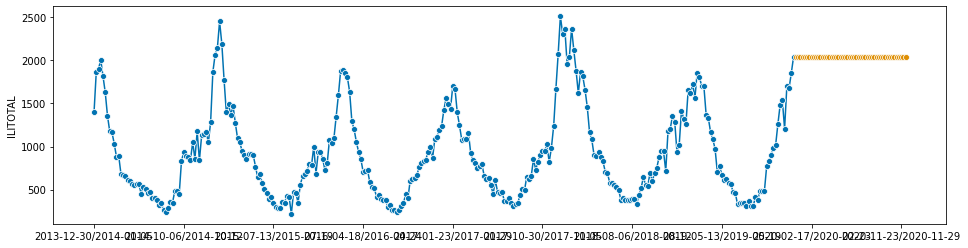

In [63]:
from copy import deepcopy

region_model_dict = {}
forecaster = NaiveForecaster(sp=1)

for ts_id, ts in main_df.groupby("REGION"):
    ts = (ts
        ["ILITOTAL"]
        .sort_index()
    )
    region_model_dict[ts_id] = deepcopy(forecaster)
    region_model_dict[ts_id].fit(ts)
    
plot_series(cali_ts, region_model_dict["California"].predict(fh=np.arange(50)+1))
plt.show()

## Approach #1: One sktime forecaster per region

In [76]:
from dsf_utils.evaluation import evaluate_panel_forecaster_on_cutoffs
from dsf_utils.plotting import plot_interactive_panel_cv_results

df = evaluate_panel_forecaster_on_cutoffs(
    main_df,
    custom_cutoffs,
    SktimePanelForecaster(forecaster=NaiveForecaster, forecaster_kwargs={"sp": 1}),
    metric = MeanSquaredScaledError(square_root=True),
)
mean_rmsse = df["Score"].mean()
print(f"Mean RMSSE across all series and all cutoffs is {mean_rmsse: 0.2f}")
plot_interactive_panel_cv_results(main_df, df)

Mean RMSSE across all series and all cutoffs is  1.23


interactive(children=(Dropdown(description='region', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkans…

In [78]:
from sktime.forecasting.tbats import TBATS
df = evaluate_panel_forecaster_on_cutoffs(
    main_df,
    custom_cutoffs,
    SktimePanelForecaster(forecaster=TBATS, forecaster_kwargs={"sp": 52}),
    metric = MeanSquaredScaledError(square_root=True),
)
mean_rmsse = df["Score"].mean()
print(f"Mean RMSSE across all series and all cutoffs is {mean_rmsse: 0.2f}")
plot_interactive_panel_cv_results(main_df, df)

Mean RMSSE across all series and all cutoffs is  1.16


interactive(children=(Dropdown(description='region', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkans…

## Approach #2: Global Forecasting Algorithms

In [101]:
from dsf_utils.models import DirectLGBMGlobalForecaster

model = DirectLGBMGlobalForecaster(
    calendar_features={"week": True, "year": False, "t": False}
)

df = evaluate_panel_forecaster_on_cutoffs(
    main_df,
    custom_cutoffs,
    model,
    metric = MeanSquaredScaledError(square_root=True),
)
mean_rmsse = df["Score"].mean()
print(f"Mean RMSSE across all series and all cutoffs is {mean_rmsse: 0.2f}")
plot_interactive_panel_cv_results(main_df, df)

Mean RMSSE across all series and all cutoffs is  0.96


interactive(children=(Dropdown(description='region', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkans…

## Analysis of the results

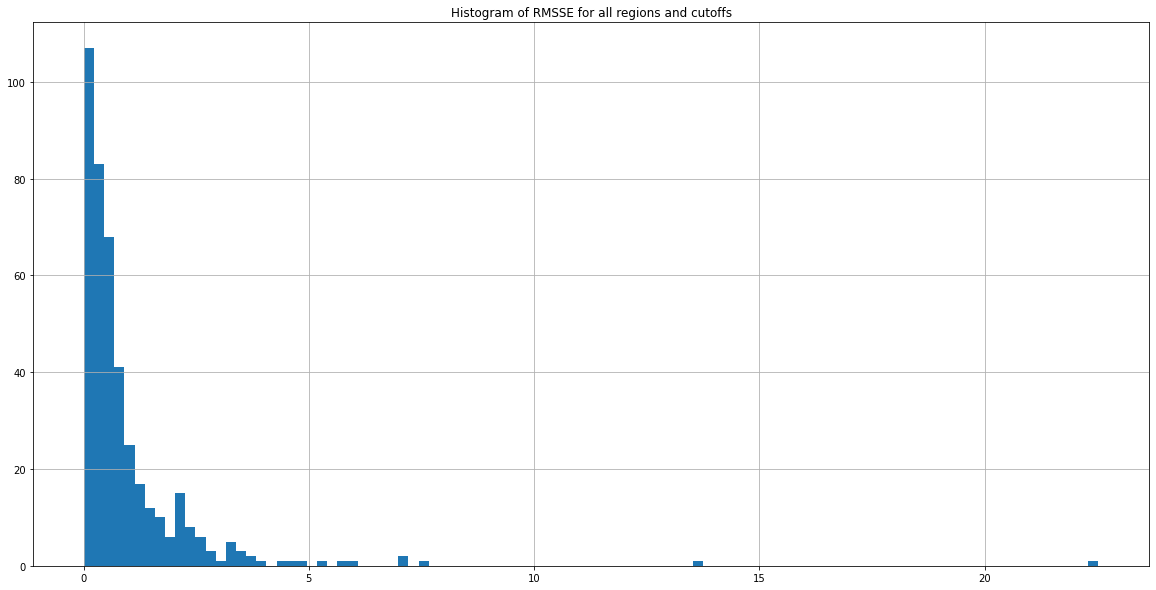

In [98]:
df["Score"].hist(bins=100)
plt.title("Histogram of RMSSE for all regions and cutoffs")
plt.show()

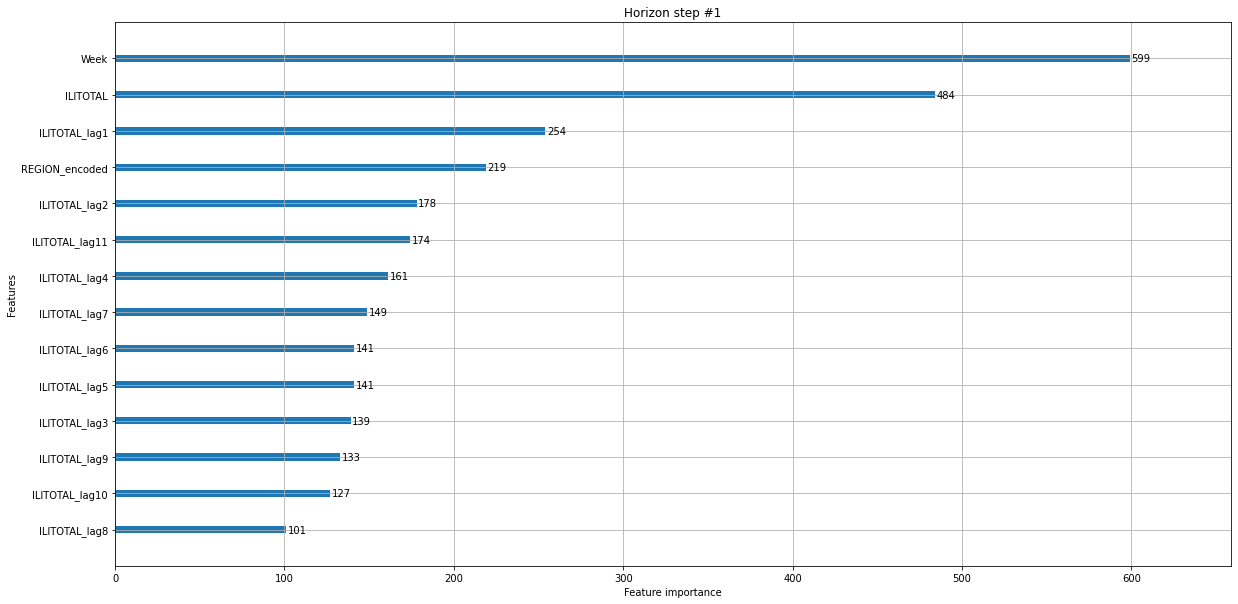

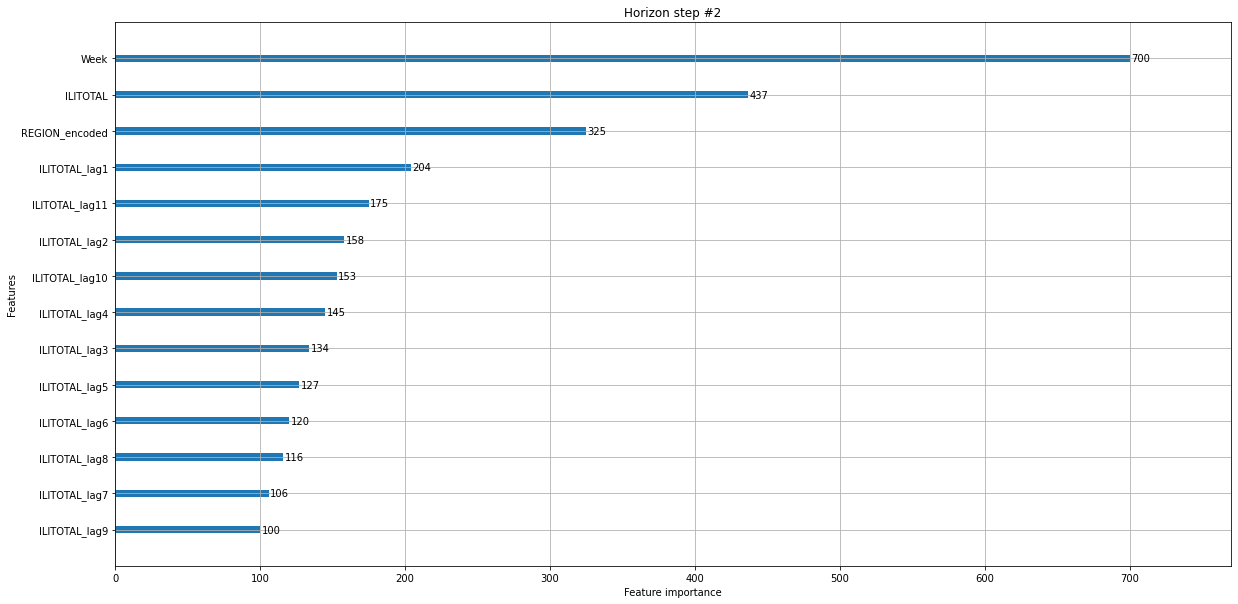

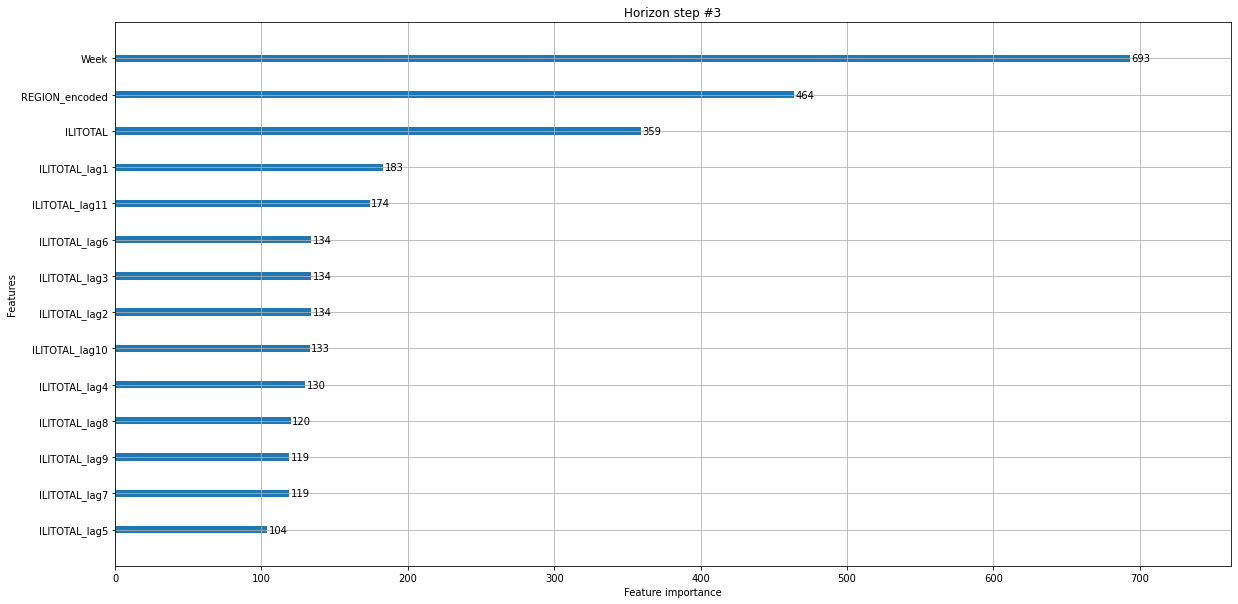

In [99]:
from lightgbm import plot_importance
fh = np.arange(3) + 1
model = DirectLGBMGlobalForecaster(
    calendar_features={"week": True, "year": False, "t": False}
)
model.fit(main_df, fh=fh)
for i in range(len(np.arange(3))):
    plot_importance(model.models[i])
    plt.title(f"Horizon step #{fh[i]}")

In [124]:
from dsf_utils.models import RecursiveLGBMGlobalForecaster

model = RecursiveLGBMGlobalForecaster(
    calendar_features={"week": True, "year": False, "t": False}
)

df = evaluate_panel_forecaster_on_cutoffs(
    main_df,
    custom_cutoffs,
    model,
    metric = MeanSquaredScaledError(square_root=True),
)
mean_rmsse = df["Score"].mean()
print(f"Mean RMSSE across all series and all cutoffs is {mean_rmsse: 0.2f}")
plot_interactive_panel_cv_results(main_df, df)

Mean RMSSE across all series and all cutoffs is  1.02


interactive(children=(Dropdown(description='region', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkans…

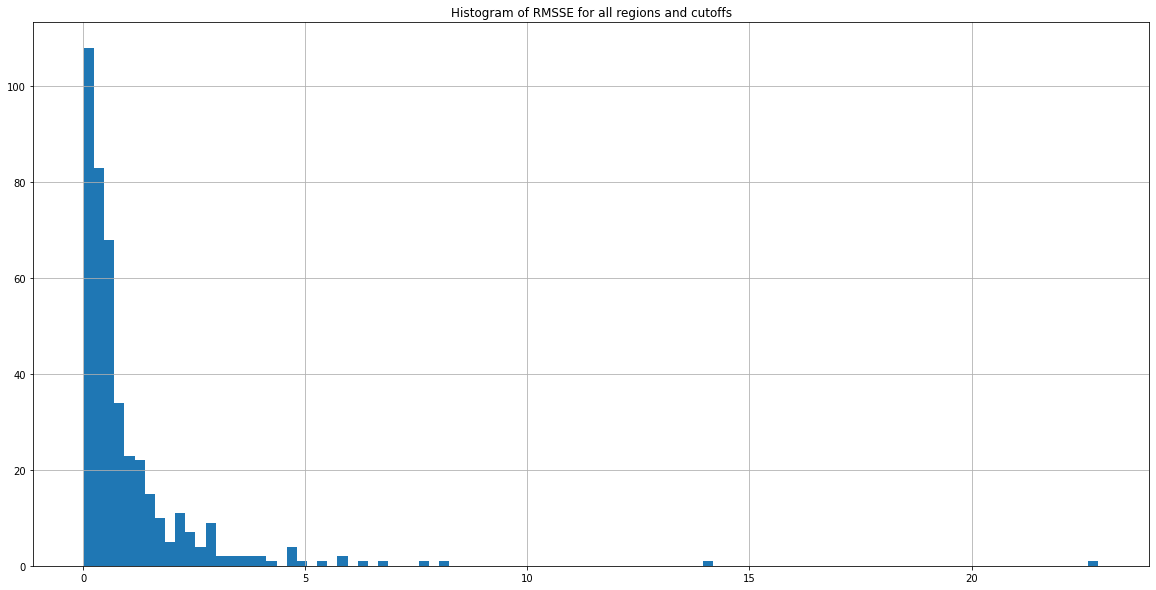

In [125]:
df["Score"].hist(bins=100)
plt.title("Histogram of RMSSE for all regions and cutoffs")
plt.show()